# Importación de Dataset

In [ ]:
import numpy as np
import pandas as pd
from  skimage.io import imread, imshow
from knn import KNN
from svm import SVM
from reglog import Regresion
import pywt
import pywt.data
import os
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from PIL import Image
from pathlib import Path

def redimensionar(path):
   imagenes=[]
   entries = Path(path)
   for entry in entries.iterdir():
      imagenes.append(path + entry.name)

   # Tamaño deseado para todas las imágenes
   ancho_deseado = 300
   alto_deseado = 200

   # Carpeta de destino para las imágenes redimensionadas
   carpeta_destino = "imagenes_1"

   # Crea la carpeta de destino si no existe
   if not os.path.exists(carpeta_destino):
      os.makedirs(carpeta_destino)

   # Recorre la lista de imágenes y redimensiona y guarda cada una
   for ruta_imagen in imagenes:
      imagen = Image.open(ruta_imagen)
      
      # Redimensiona la imagen al tamaño deseado con interpolación ANTIALIAS
      imagen_redimensionada = imagen.resize((ancho_deseado, alto_deseado), Image.ADAPTIVE)
      
      # Obtiene el nombre de archivo sin la ruta
      nombre_archivo = os.path.basename(ruta_imagen)
      
      # Define la ruta de archivo de destino en la carpeta de destino
      ruta_destino = os.path.join(carpeta_destino, nombre_archivo)
      
      # Guarda la imagen redimensionada en la carpeta de destino
      imagen_redimensionada.save(ruta_destino)     

def Get_Feacture(picture, cortes):
  LL = picture
  for i in range(cortes):
     LL, (LH, HL, HH) = pywt.dwt2(LL, 'haar')
  return LL.flatten().tolist()

def cargar_dataset():

    carpeta_imagenes = './imagenes_1/'

    # Se ordena los archivos segun el nombre asignado
    archivos = os.listdir(carpeta_imagenes)

    clases = []
    vectores_caracteristicos = []


    for archivo in archivos:
        # Verifica si el archivo es una imagen (puedes agregar más extensiones si es necesario)
        if archivo.endswith(('.png')):
            # Construye la ruta completa del archivo
            ruta_completa = os.path.join(carpeta_imagenes, archivo)
            imagen = imread(ruta_completa)

            # Se añade la clase correspondiente al vector clases 
            if int(archivo[1]) < 1:
                clases.append(int(archivo[2]))
            else:
                clases.append(int(archivo[1:3]))

            # Se añade el vector caracteristico de cada imagen
            vectores_caracteristicos.append(Get_Feacture(imagen, 2))

    return vectores_caracteristicos,clases

def acuary(y_prueba,y_correct):
    correctos= np.sum(y_prueba == y_correct)
    return (correctos/len(y_correct))*100      

  
# Redimensionamos las imagenes para trabajar todas con el mismo tamaño
redimensionar("./images/")

# Definimos el dataset
x,y= cargar_dataset()

x=np.array(x)
y=np.array(y)

# Modelo Regresión Logistica
#### Validacion por K-fold cross validation


In [7]:
# Definimos el número de folds
k = 5

# Mezclamos los datos aleatoriamente
indices = np.arange(len(x))
np.random.shuffle(indices)
X = x[indices]
Y = y[indices]


# Divide los datos en k grupos
X_folds = np.array_split(X, k)
Y_folds = np.array_split(Y, k)



# Lista para almacenar los porcentajes de rendimiento
accuracies=[]

# Realizamos k iteraciones
for i in range(k):
    # Selecciona el conjunto de prueba y entrenamiento actual
    X_test = X_folds[i]
    Y_test = Y_folds[i]
    
    X_train = np.concatenate([X_folds[j] for j in range(k) if j != i])
    Y_train = np.concatenate([Y_folds[j] for j in range(k) if j != i])
    
    #Creamos y entrenamos el modelo.

    # Iniciar Regresion
    clasificador = Regresion(700,0.00000001)
    clasificador.train(X_train, Y_train)
    
    # Evalúa el modelo en el conjunto de prueba
    y_pred_test = clasificador.predict(X_test)
    porcentaje_aciertos=acuary(y_pred_test,Y_test)   
    
    # Almacena la precisión en la lista de accuracies
    accuracies.append(porcentaje_aciertos)


# Calcula la precisión promedio de precion en cada K-fold
average_accuracy = np.mean(accuracies)
print(f'Precisión promedio: {average_accuracy:.2f}%')

Precisión promedio: 34.02%


#### Validacion por division del dataset en 70% entrenamiento 15% validación, 15% prueba.

In [8]:
# Definimos los tamaños de los conjuntos (70% entrenamiento, 15% validación, 15% prueba)
total_samples = len(x)
train = int(0.7 * total_samples)
validation = int(0.15 * total_samples)

# Dividimoss los datos en conjuntos de entrenamiento, validación y prueba
X_train = x[:train]
y_train = y[:train]

X_val = x[train:train + validation]
y_val = y[train:train + validation]

X_test = x[train + validation:]
y_test = y[train + validation:]

# Crear y entrenar el modelo
modelo = Regresion(1000,0.00000001)
modelo.train(X_train, y_train)

# Validacion
y_pred_val = modelo.predict(X_val)
precision_val=acuary(y_val,y_pred_val)

print(f"Precisión en el conjunto de validación: {precision_val:.2f}%")

# Predicción
y_pred_test = modelo.predict(X_test)
precision_test=acuary(y_test,y_pred_test)

print(f"Precisión en el conjunto de testeo: {precision_test:.2f}%")

Precisión en el conjunto de validación: 38.71%
Precisión en el conjunto de testeo: 32.54%


#### Evaluamos la precision, Recall y  F1-Score

In [9]:
classification_rep = classification_report(y_test, y_pred_test)
print("Informe de Clasificación:")
print(classification_rep)

Informe de Clasificación:
              precision    recall  f1-score   support

           1       0.22      0.33      0.27        12
           2       0.25      0.27      0.26        15
           3       0.60      0.30      0.40        10
           4       0.07      0.12      0.09         8
           5       0.22      0.44      0.30         9
           6       0.41      0.50      0.45        14
           7       0.67      0.47      0.55        17
           8       0.36      0.73      0.48        11
           9       0.50      0.12      0.19        17
          10       0.00      0.00      0.00        13

    accuracy                           0.33       126
   macro avg       0.33      0.33      0.30       126
weighted avg       0.35      0.33      0.31       126



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

#### Matriz de confusión

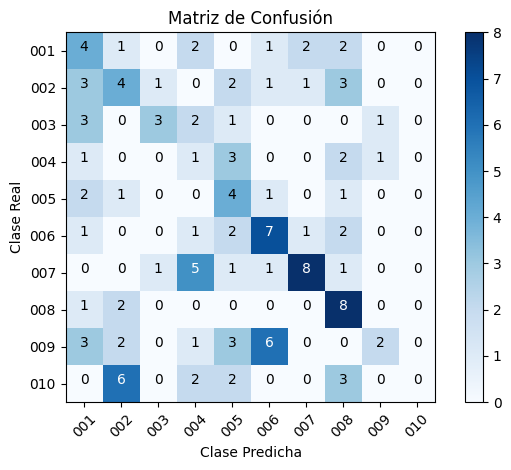

In [10]:
import matplotlib.pyplot as plt

# Calcula la matriz de confusión
confusion = confusion_matrix(y_test, y_pred_test)

# Define las etiquetas de las clases
classes = ["001", "002", "003", "004", "005", "006", "007", "008", "009", "010"]  # Clases negativa y positiva

# Crea la figura y los ejes
plt.figure()
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Etiqueta los valores en la matriz
thresh = confusion.max() / 2.
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, format(confusion[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion[i, j] > thresh else "black")

plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.tight_layout()
plt.show()

# Modelo KNN
#### Validacion por K-fold cross validation


In [11]:
# Definimos el número de folds
k = 5

# Mezclamos los datos aleatoriamente
indices = np.arange(len(x))
np.random.shuffle(indices)
X = x[indices]
Y = y[indices]


# Divide los datos en k grupos
X_folds = np.array_split(X, k)
Y_folds = np.array_split(Y, k)



# Lista para almacenar los porcentajes de rendimiento
accuracies=[]

# Realizamos k iteraciones
for i in range(k):
    # Selecciona el conjunto de prueba y entrenamiento actual
    X_test = X_folds[i]
    Y_test = Y_folds[i]
    
    X_train = np.concatenate([X_folds[j] for j in range(k) if j != i])
    Y_train = np.concatenate([Y_folds[j] for j in range(k) if j != i])
    
    #Creamos y entrenamos el modelo.

    # Iniciar KNN
    clasificador = KNN(k=5)
    clasificador.aprendizaje(X_train.T,Y_train)
    
    # Evalúa el modelo en el conjunto de prueba
    y_pred=clasificador.clasificacion(X_test.T)
    porcentaje_aciertos=acuary(y_pred,Y_test)    
    
    # Almacena la precisión en la lista de accuracies
    accuracies.append(porcentaje_aciertos)


# Calcula la precisión promedio de precion en cada K-fold
average_accuracy = np.mean(accuracies)
print(f'Precisión promedio: {average_accuracy:.2f}%')

# Evaluamos la precision, Recall y  F1-Score
classification_rep = classification_report(Y_test, y_pred)
print("Informe de Clasificación:")
print(classification_rep)

Precisión promedio: 22.60%
Informe de Clasificación:
              precision    recall  f1-score   support

           1       0.50      0.31      0.38        13
           2       1.00      0.07      0.12        15
           3       0.50      0.07      0.12        14
           4       0.04      0.05      0.04        20
           5       0.17      0.32      0.22        19
           6       0.56      0.29      0.38        17
           7       0.00      0.00      0.00        22
           8       0.75      0.75      0.75        12
           9       0.22      0.10      0.14        20
          10       0.15      0.64      0.24        14

    accuracy                           0.23       166
   macro avg       0.39      0.26      0.24       166
weighted avg       0.35      0.23      0.21       166



#### Validacion por division del dataset en 70% entrenamiento 15% validación, 15% prueba.

In [12]:
# Mezclamos los datos aleatoriamente
indices = np.arange(len(x))
np.random.shuffle(indices)
X = x[indices]
Y = y[indices]

total_samples = len(X)
train = int(0.7 * total_samples)
validation = int(0.15 * total_samples)

# Dividimoss los datos en conjuntos de entrenamiento, validación y prueba
X_train = X[:train]
y_train = Y[:train]

X_val = X[train:train + validation]
y_val = Y[train:train + validation]

X_test = X[train + validation:]
y_test = Y[train + validation:]

#Entrenamos el modelo
clasificador = KNN(k=5)
clasificador.aprendizaje(X_train.T,y_train)

# Evalúa el modelo en el conjunto de validacion
y_val_pred=clasificador.clasificacion(X_val.T)
aciertos_val=acuary(y_val_pred,y_val)

print(f"Precisión en el conjunto de validación: {aciertos_val:.2f}")


# Evalúa el modelo en el conjunto de prueba
y_test_pred=clasificador.clasificacion(X_test.T)
aciertos_prue=acuary(y_test_pred,y_test)

print(f"Precisión en el conjunto de prueba: {aciertos_prue:.2f}")

Precisión en el conjunto de validación: 25.00
Precisión en el conjunto de prueba: 15.87


#### Evaluamos la precision, Recall y  F1-Score

In [13]:
classification_rep = classification_report(y_test, y_pred_test)
print("Informe de Clasificación:")
print(classification_rep)

Informe de Clasificación:
              precision    recall  f1-score   support

           1       0.33      0.38      0.35        16
           2       0.06      0.14      0.09         7
           3       0.00      0.00      0.00         7
           4       0.07      0.10      0.08        10
           5       0.00      0.00      0.00        11
           6       0.12      0.11      0.11        19
           7       0.00      0.00      0.00        13
           8       0.05      0.20      0.07         5
           9       0.25      0.04      0.07        25
          10       0.00      0.00      0.00        13

    accuracy                           0.10       126
   macro avg       0.09      0.10      0.08       126
weighted avg       0.12      0.10      0.09       126



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

#### Matriz de confusión

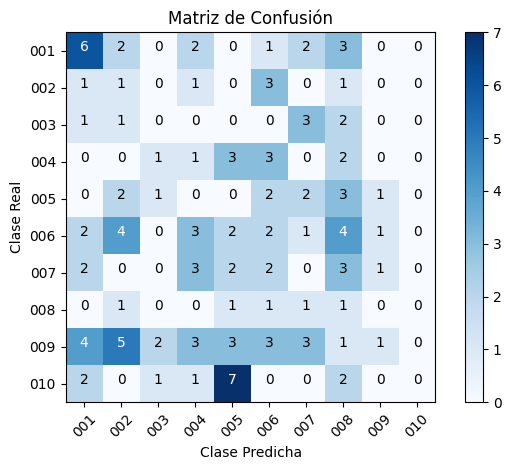

In [14]:
import matplotlib.pyplot as plt

# Calcula la matriz de confusión
confusion = confusion_matrix(y_test, y_pred_test)

# Define las etiquetas de las clases
classes = ["001", "002", "003", "004", "005", "006", "007", "008", "009", "010"]  # Clases negativa y positiva

# Crea la figura y los ejes
plt.figure()
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Etiqueta los valores en la matriz
thresh = confusion.max() / 2.
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, format(confusion[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion[i, j] > thresh else "black")

plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.tight_layout()
plt.show()

# Modelo SVM
#### Validacion por K-fold cross validation


In [15]:
# Definimos el número de folds
k = 5

# Mezclamos los datos aleatoriamente
indices = np.arange(len(x))
np.random.shuffle(indices)
X = x[indices]
Y = y[indices]


# Divide los datos en k grupos
X_folds = np.array_split(X, k)
Y_folds = np.array_split(Y, k)



# Lista para almacenar los porcentajes de rendimiento
accuracies=[]

# Realizamos k iteraciones
for i in range(k):
    # Selecciona el conjunto de prueba y entrenamiento actual
    X_test = X_folds[i]
    Y_test = Y_folds[i]
    
    X_train = np.concatenate([X_folds[j] for j in range(k) if j != i])
    Y_train = np.concatenate([Y_folds[j] for j in range(k) if j != i])
    
    #Creamos y entrenamos el modelo.

    # Iniciar Regresion
    clasificador = SVM(1,300,0.0000001)
    clasificador.fit(X_train, Y_train)
    
    # Evalúa el modelo en el conjunto de prueba
    y_pred_test = clasificador.prediccion(X_test)
    porcentaje_aciertos=acuary(y_pred_test,Y_test)   
    
    # Almacena la precisión en la lista de accuracies
    accuracies.append(porcentaje_aciertos)


# Calcula la precisión promedio de precion en cada K-fold
average_accuracy = np.mean(accuracies)
print(f'Precisión promedio: {average_accuracy:.2f}%') 

Precisión promedio: 31.37%


#### Validacion por division del dataset en 70% entrenamiento 15% validación, 15% prueba.

In [16]:
# Definimos los tamaños de los conjuntos (70% entrenamiento, 15% validación, 15% prueba)
total_samples = len(x)
train = int(0.7 * total_samples)
validation = int(0.15 * total_samples)

# Dividimoss los datos en conjuntos de entrenamiento, validación y prueba
X_train = x[:train]
y_train = y[:train]

X_val = x[train:train + validation]
y_val = y[train:train + validation]

X_test = x[train + validation:]
y_test = y[train + validation:]

# Crear y entrenar el modelo
modelo = SVM(1,300,0.0000001)
modelo.fit(X_train, y_train)

# Validacion
y_pred_val = modelo.prediccion(X_val)
precision_val=acuary(y_val,y_pred_val)

print(f"Precisión en el conjunto de validación: {precision_val:.2f}")

# Predicción
y_pred_test = modelo.prediccion(X_test)
precision_test=acuary(y_test,y_pred_test)

print(f"Precisión en el conjunto de testeo: {precision_test:.2f}")

Precisión en el conjunto de validación: 33.06
Precisión en el conjunto de testeo: 35.71


#### Evaluamos la precision, Recall y  F1-Score

In [17]:
classification_rep = classification_report(y_test, y_pred_test)
print("Informe de Clasificación:")
print(classification_rep)

Informe de Clasificación:
              precision    recall  f1-score   support

           1       0.30      0.25      0.27        12
           2       0.25      0.27      0.26        15
           3       0.50      0.40      0.44        10
           4       0.10      0.12      0.11         8
           5       0.19      0.44      0.27         9
           6       0.43      0.43      0.43        14
           7       0.77      0.59      0.67        17
           8       0.42      0.73      0.53        11
           9       0.40      0.24      0.30        17
          10       0.20      0.08      0.11        13

    accuracy                           0.36       126
   macro avg       0.36      0.35      0.34       126
weighted avg       0.38      0.36      0.35       126



#### Matriz de confusión

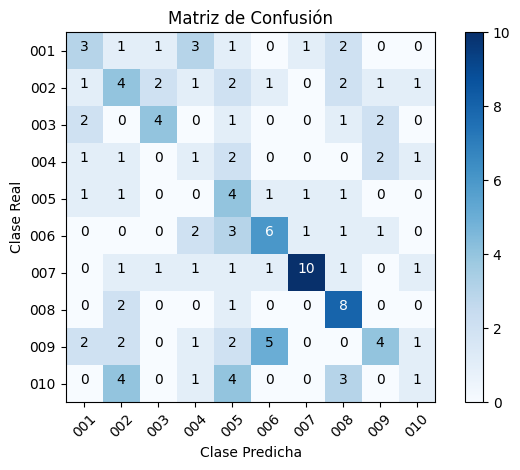

In [18]:
import matplotlib.pyplot as plt

# Calcula la matriz de confusión
confusion = confusion_matrix(y_test, y_pred_test)

# Define las etiquetas de las clases
classes = ["001", "002", "003", "004", "005", "006", "007", "008", "009", "010"]  # Clases negativa y positiva

# Crea la figura y los ejes
plt.figure()
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Etiqueta los valores en la matriz
thresh = confusion.max() / 2.
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, format(confusion[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion[i, j] > thresh else "black")

plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.tight_layout()
plt.show()

# Modelo Arboles de Desición

In [21]:
import numpy as np
import pandas as pd
from skimage.io import imread, imshow
from pathlib import Path
from dt import TreeNode,DT
import pywt
import pywt.data
from PIL import Image
from sklearn.decomposition import PCA # Para reducir la dimensionalidad
from sklearn.preprocessing import StandardScaler # Para hacer la normalización
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Partición de la imagen en su esquina superior izquierda
def Get_Feacture(picture, cortes):
    LL = picture.copy()
    for i in range(cortes): # Se corta la cantidad de veces determinada (2)
        LL, (LH, HL, HH) = pywt.dwt2(LL, 'haar')
    return LL.flatten().tolist() # Se convierte esta matriz representativa en un vector característico

def Cargar_dataset_arbol():

    path = './imagenes_1/'

    vectores_caracteristicos = []

    entries = Path(path)

    # Iteramos la lista de directorios
    for entry in entries.iterdir():
        imagen = path + entry.name
        picture = imread(imagen)
        vector_caracteristico = Get_Feacture(picture, 2) # Se extrae el vector característico
        vector_caracteristico.append(entry.name[0:3]) # Se agrega el label
        vectores_caracteristicos.append(vector_caracteristico) # Agregamos ese nuevo vector característico

    # Convertimos a numpy los datos de entrada
    X = np.array(vectores_caracteristicos)[:, :-1]  # Elimina la última columna (labels) para dejar solo los datos de entrada

    # Aplicamos PCA para reducir la dimensionalidad
    pca = PCA(n_components=200) # Elegimos el número de componentes principales
    X_pca = pca.fit_transform(X)

    # Normalizamos los datos
    scaler = StandardScaler()
    X_pca_normalized = scaler.fit_transform(X_pca)


    # Obtenemos la lista de etiquetas
    labels = np.array(vectores_caracteristicos)[:, -1]

    return X_pca_normalized,labels

# Definimos el dataset
x,y= Cargar_dataset_arbol()

x=np.array(x)
y=np.array(y)


In [22]:
# Partición del dataset normalizado, junto con los labels
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Creamos una instancia de DT con los datos de entrenamiento
dt = DT(X_train, y_train, index=0)

# Realizamos predicciones en el conjunto de prueba
y_pred = dt.fit(X_test)

#### Matriz de Confusión

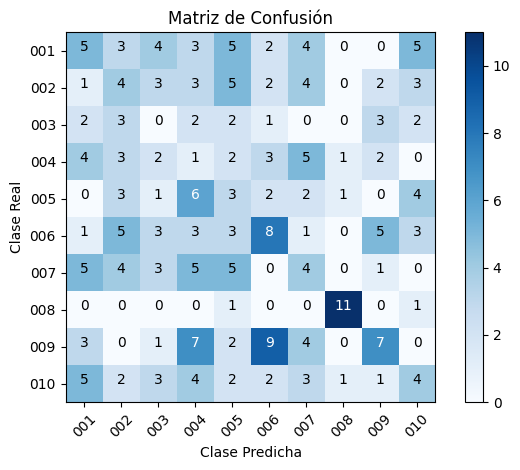

In [23]:
import matplotlib.pyplot as plt

# Calcula la matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Define las etiquetas de las clases
classes = ["001", "002", "003", "004", "005", "006", "007", "008", "009", "010"]  # Clases negativa y positiva

# Crea la figura y los ejes
plt.figure()
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Etiqueta los valores en la matriz
thresh = confusion.max() / 2.
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, format(confusion[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion[i, j] > thresh else "black")

plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.tight_layout()
plt.show()

#### Validacion por Bootstrap

In [24]:
# Cantidad de árboles
num_trees = 2 

# Lista para almacenar las predicciones de cada árbol
all_predictions = []

# Partición del dataset normalizado, junto con las etiquetas
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

for _ in range(num_trees):
    # Creamos una muestra de bootstrap
    indices = np.random.choice(len(X_train), len(X_train), replace=True)
    X_bootstrapped = X_train[indices]
    y_bootstrapped = y_train[indices]

    # Crear una instancia de DT con estos datos
    dt = DT(X_bootstrapped, y_bootstrapped, index=0)

    # Realizamos predicciones en el conjunto de prueba
    y_pred = dt.fit(X_test)
    
    # Almacenar las predicciones de este árbol
    all_predictions.append(y_pred)

all_predictions = [np.array(pred).astype(float) for pred in all_predictions]

# Promediamos las predicciones de todos los árboles
ensemble_predictions = np.mean(all_predictions, axis=0)

# Convertimos las predicciones
ensemble_predictions = np.round(ensemble_predictions).astype(int)

print(ensemble_predictions)

y_test = [int(label) for label in y_test]

TypeError: DT.predict() missing 1 required positional argument: 'node'

#### Evaluamos la precision, Recall y  F1-Score

In [ ]:
# Informe de clasificación
classification_rep = classification_report(y_test, ensemble_predictions)
print("Informe de Clasificación del Ensemble:")
print(classification_rep)